<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day15_Rain_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

!pip install imbalanced-learn -q
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Imbpipeline

from sklearn.metrics import(
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

from scipy import stats
import joblib
plt.style.use('seaborn-v0_8-whitegrid')

In [38]:
url = "https://rattle.togaware.com/weatherAUS.csv"

df = pd.read_csv(url)

print(f"{df.shape[0]:,} observations, {df.shape[1]:,} columns")
print(f"Range: {df['Date'].min()} to {df['Date'].max()}")

275,410 observations, 24 columns
Range: 2007-11-01 to 2026-01-30


In [39]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275410 entries, 0 to 275409
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           275410 non-null  object 
 1   Location       275410 non-null  object 
 2   MinTemp        270732 non-null  float64
 3   MaxTemp        270779 non-null  float64
 4   Rainfall       267316 non-null  float64
 5   Evaporation    115284 non-null  float64
 6   Sunshine       104284 non-null  float64
 7   WindGustDir    254944 non-null  object 
 8   WindGustSpeed  255145 non-null  float64
 9   WindDir9am     253956 non-null  object 
 10  WindDir3pm     263004 non-null  object 
 11  WindSpeed9am   269462 non-null  float64
 12  WindSpeed3pm   264722 non-null  float64
 13  Humidity9am    269181 non-null  float64
 14  Humidity3pm    263949 non-null  float64
 15  Pressure9am    245025 non-null  float64
 16  Pressure3pm    245048 non-null  float64
 17  Cloud9am       148891 non-nul

In [41]:
print(df['RainTomorrow'].value_counts())
print(f"\nRain rate: {(df['RainTomorrow'] == 'Yes').mean():.1f}")

RainTomorrow
No     208393
Yes     58924
Name: count, dtype: int64

Rain rate: 0.2


EDA

In [42]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

#Remove target from categorical
if 'RainTomorrow' in categorical_cols:
  categorical_cols.remove('RainTomorrow')

if 'Date' in categorical_cols:
  categorical_cols.remove('Date')

print(f"Numeric columns: {len(numeric_cols)} : {numeric_cols}")
print(f"Categorical columns: {len(categorical_cols)} : {categorical_cols}")


Numeric columns: 17 : ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']
Categorical columns: 5 : ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [43]:
df[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,270732.00,270779.00,267316.00,115284.00,104284.00,255145.00,269462.00,264722.00,269181.00,263949.00,245025.00,245048.00,148891.00,142702.00,270776.00,265428.00,267317.00
mean,12.10,23.26,2.34,5.49,7.63,39.99,14.05,18.53,69.08,51.46,1017.66,1015.23,4.78,4.73,16.94,21.75,2.34
std,6.43,7.14,8.61,4.14,3.78,13.50,8.82,8.68,19.39,21.03,7.10,7.05,2.90,2.77,6.53,7.00,8.61
min,-8.70,-4.10,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,978.60,972.00,0.00,0.00,-6.20,-5.10,0.00
25%,7.50,18.00,0.00,2.80,4.90,31.00,7.00,13.00,57.00,36.00,1012.90,1010.40,2.00,2.00,12.20,16.70,0.00
50%,11.90,22.70,0.00,4.80,8.50,39.00,13.00,17.00,70.00,52.00,1017.60,1015.20,6.00,5.00,16.70,21.20,0.00
75%,16.80,28.20,0.60,7.40,10.60,48.00,19.00,24.00,84.00,66.00,1022.50,1020.10,7.00,7.00,21.50,26.50,0.60
max,33.90,49.60,474.00,138.70,14.50,154.00,87.00,87.00,100.00,100.00,1042.50,1040.30,9.00,9.00,41.00,48.20,474.00


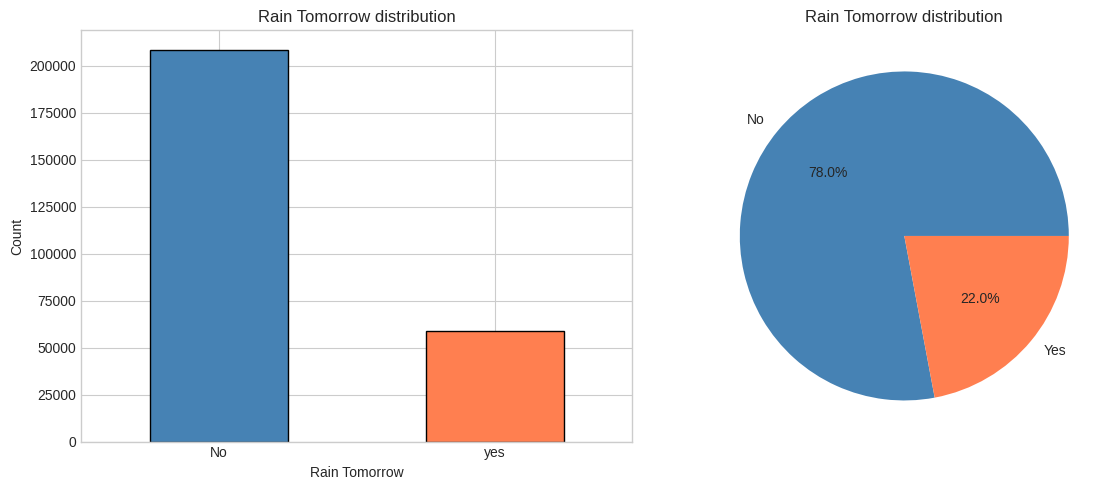

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['RainTomorrow'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title("Rain Tomorrow distribution")
axes[0].set_xlabel("Rain Tomorrow")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(['No', 'yes'], rotation=0)


df['RainTomorrow'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['steelblue', 'coral'])
axes[1].set_title("Rain Tomorrow distribution")
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

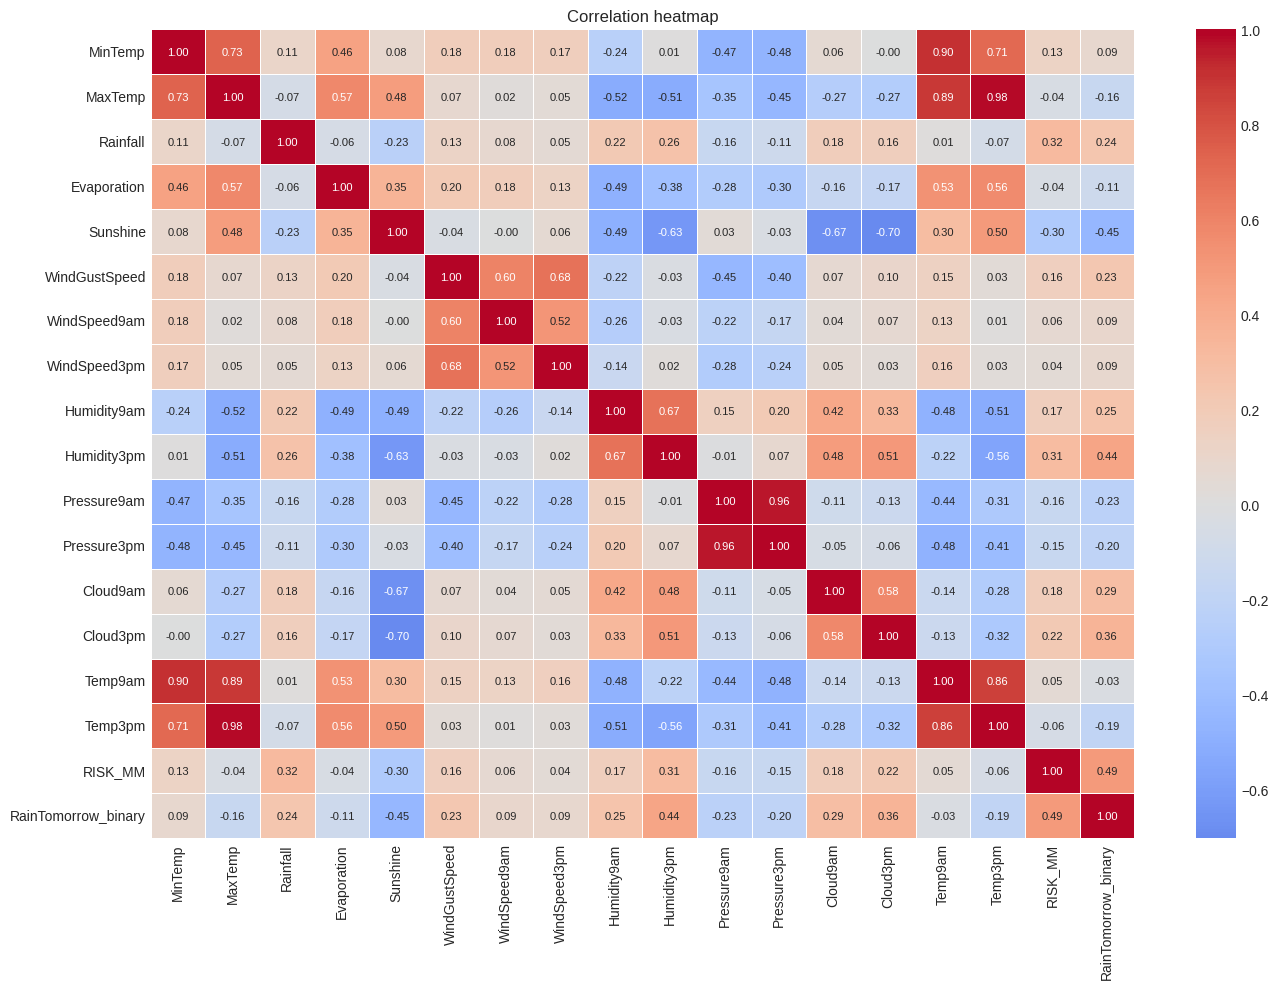

In [45]:
#We can see that we have an imbalannced dataset
fig, ax = plt.subplots(figsize=(14, 10))

df_corr = df.copy()
df_corr['RainTomorrow_binary'] = (df_corr['RainTomorrow'] == 'Yes').astype(int)

corr_matrix = df_corr[numeric_cols + ['RainTomorrow_binary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidth=0.5, ax=ax, annot_kws={'size': 8})
ax.set_title("Correlation heatmap")

plt.tight_layout()
plt.show()

In [46]:
#Top correlations with target
target_corr = corr_matrix['RainTomorrow_binary'].drop("RainTomorrow_binary").sort_values(key=abs, ascending=False)

print("Top correlations")
print(target_corr.head(10))

Top correlations
RISK_MM          0.494731
Sunshine        -0.447790
Humidity3pm      0.439746
Cloud3pm         0.359731
Cloud9am         0.288788
Humidity9am      0.251153
Rainfall         0.239025
WindGustSpeed    0.231012
Pressure9am     -0.229678
Pressure3pm     -0.204602
Name: RainTomorrow_binary, dtype: float64


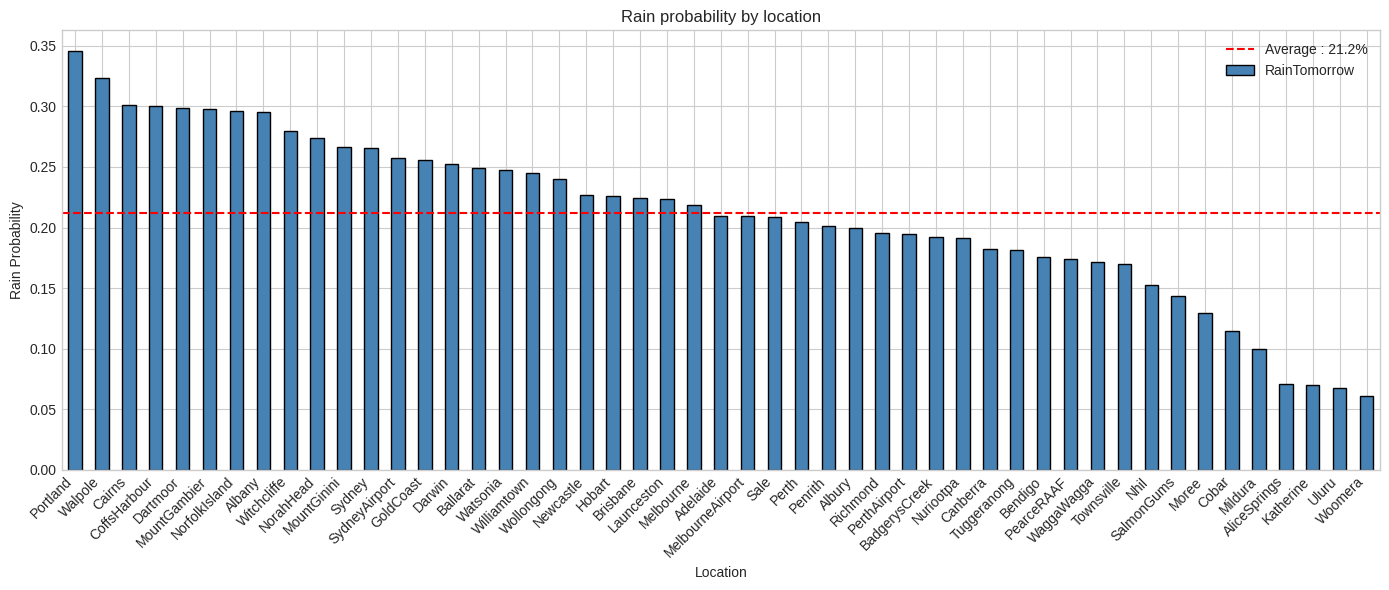

In [47]:
#location analysis
location_rain = df.groupby('Location')['RainTomorrow'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
location_rain.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.axhline(y=location_rain.mean(), color='red', linestyle='--', label=f"Average : {location_rain.mean():.1%}")
ax.set_ylabel("Rain Probability")
ax.set_xlabel('Location')
ax.set_title("Rain probability by location")
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Missing Data Analysis

In [48]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count' : missing,
    'Missing %' : missing_pct
}).sort_values('Missing %', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

               Missing Count  Missing %
Sunshine              171126      62.13
Evaporation           160126      58.14
Cloud3pm              132708      48.19
Cloud9am              126519      45.94
Pressure9am            30385      11.03
Pressure3pm            30362      11.02
WindDir9am             21454       7.79
WindGustDir            20466       7.43
WindGustSpeed          20265       7.36
WindDir3pm             12406       4.50
Humidity3pm            11461       4.16
WindSpeed3pm           10688       3.88
Temp3pm                 9982       3.62
Rainfall                8094       2.94
RISK_MM                 8093       2.94
RainToday               8094       2.94
RainTomorrow            8093       2.94
Humidity9am             6229       2.26
WindSpeed9am            5948       2.16
MinTemp                 4678       1.70
MaxTemp                 4631       1.68
Temp9am                 4634       1.68


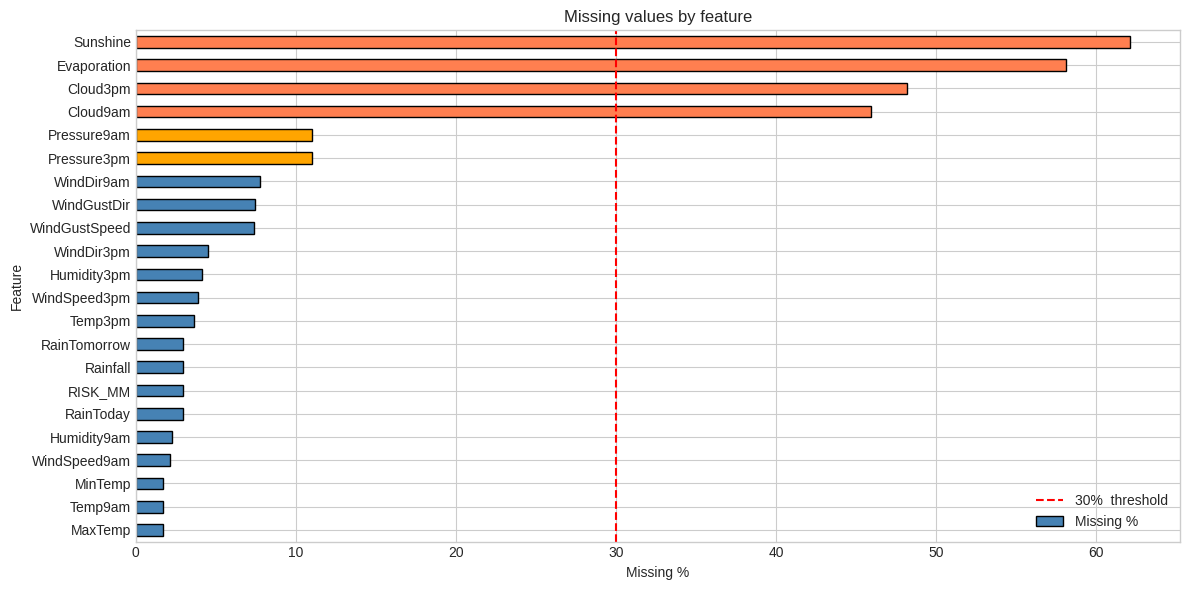

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
missing_to_plot = missing_df[missing_df['Missing %'] > 0]['Missing %'].sort_values(ascending=True)
colors = ['coral' if x > 30 else 'orange' if x > 10 else 'steelblue' for x in missing_to_plot]

missing_to_plot.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel("Missing %")
ax.set_ylabel("Feature")
ax.set_title("Missing values by feature")
ax.axvline(x=30, color='red', linestyle='--', label='30%  threshold')
ax.legend()

plt.tight_layout()
plt.show()

In [50]:
#Checking if missing is related to target (MAR vs MCAR)
for col in ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']:
  rain_missing = df[df['RainTomorrow'] == 'Yes'][col].isnull().mean()
  no_rain_missing = df[df['RainTomorrow'] == 'No'][col].isnull().mean()
  print(f"Rain = Yes missing {rain_missing:.1%}")
  print(f"Rain = No missing {no_rain_missing:.1%}")
  print()

Rain = Yes missing 60.7%
Rain = No missing 61.8%

Rain = Yes missing 57.7%
Rain = No missing 57.4%

Rain = Yes missing 39.0%
Rain = No missing 49.6%

Rain = Yes missing 37.9%
Rain = No missing 47.0%



1. Drop rows with missing target (RainTomorrow) — can't predict without target
2. Numeric features: Impute with MEDIAN (robust to outliers)
3. Categorical features: Impute with MODE (most frequent)
4. Consider dropping Sunshine, Evaporation (>40% missing) — or keep and let model handle

In [51]:
df_clean = df.copy()

#Drop rows with missing target
df_clean.dropna(subset=['RainTomorrow'])
print(f"After dropping missing Target: {len(df_clean):,} rows")

After dropping missing Target: 275,410 rows


Distribution Analysis

In [52]:
#Checking skewness of numeric features
skewness = df_clean[numeric_cols].skew().sort_values(key=abs, ascending=False)

print("Skewness")
print(skewness)


Skewness
RISK_MM          10.553944
Rainfall         10.553816
Evaporation       3.853239
WindGustSpeed     0.866414
WindSpeed9am      0.746344
WindSpeed3pm      0.638247
Sunshine         -0.502874
Humidity9am      -0.480675
Cloud9am         -0.376396
Cloud3pm         -0.306858
Temp3pm           0.236696
MaxTemp           0.230587
Temp9am           0.087727
Pressure9am      -0.071901
Humidity3pm       0.035956
MinTemp           0.027648
Pressure3pm      -0.026596
dtype: float64


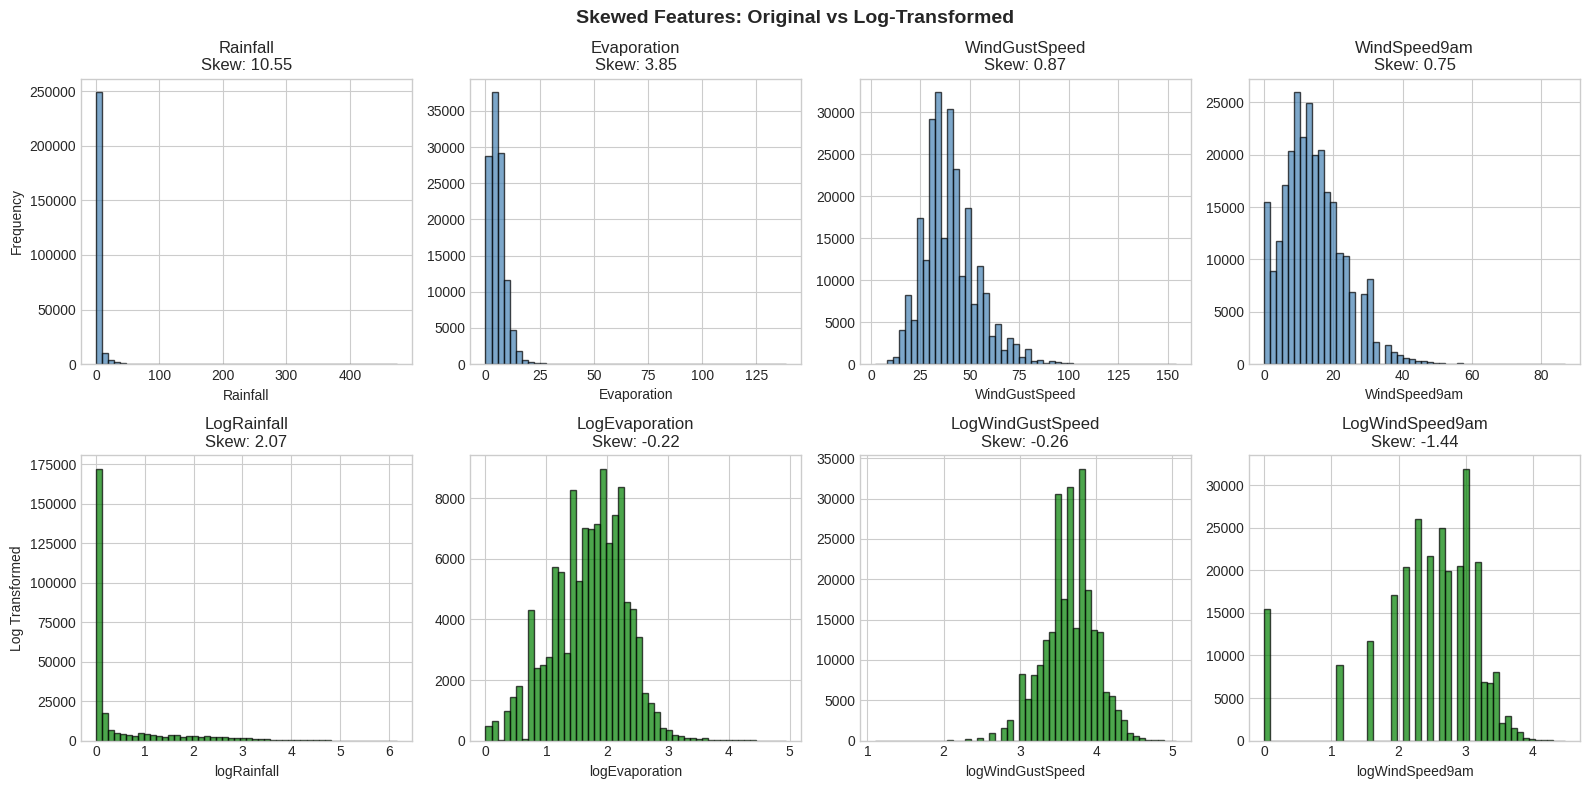

In [53]:
#Visualizing most skewed features
skewed_features = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(skewed_features):
  #original distribution
  axes[0, i].hist(df_clean[col].dropna(), bins=50, color='steelblue', edgecolor='black',alpha=0.7)
  axes[0, i].set_title(f"{col}\nSkew: {df_clean[col].skew():.2f}")
  axes[0, i].set_xlabel(col)

  #log-transformed
  log_data = np.log1p(df_clean[col].dropna())
  axes[1, i].hist(log_data, bins=50, color='green', edgecolor='black', alpha=0.7)
  axes[1, i].set_title(f"Log{col}\nSkew: {log_data.skew():.2f}")
  axes[1, i].set_xlabel(f"log{col}")

axes[0, 0].set_ylabel("Frequency")
axes[1, 0].set_ylabel("Log Transformed")

plt.suptitle('Skewed Features: Original vs Log-Transformed', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Outlier Detection

In [54]:
def count_outliers_iqr(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR
  return ((series < lower) | (series > upper)).sum()

outlier_counts = {}
for col in numeric_cols:
  count = count_outliers_iqr(df_clean[col].dropna())
  pct = count / df_clean[col].notna().sum() * 100
  outlier_counts[col] = {'count': count, 'pct': pct}

outlier_df = pd.DataFrame(outlier_counts).T.sort_values('pct', ascending=False)

print(outlier_df.round(2))

                 count    pct
Rainfall       53540.0  20.03
RISK_MM        53535.0  20.03
Evaporation     3012.0   2.61
WindGustSpeed   5579.0   2.19
WindSpeed3pm    4373.0   1.65
WindSpeed9am    3191.0   1.18
Humidity9am     2310.0   0.86
Pressure9am     1765.0   0.72
Temp3pm         1610.0   0.61
Pressure3pm     1350.0   0.55
MaxTemp         1193.0   0.44
Temp9am          648.0   0.24
MinTemp          111.0   0.04
Sunshine           0.0   0.00
Humidity3pm        0.0   0.00
Cloud9am           0.0   0.00
Cloud3pm           0.0   0.00


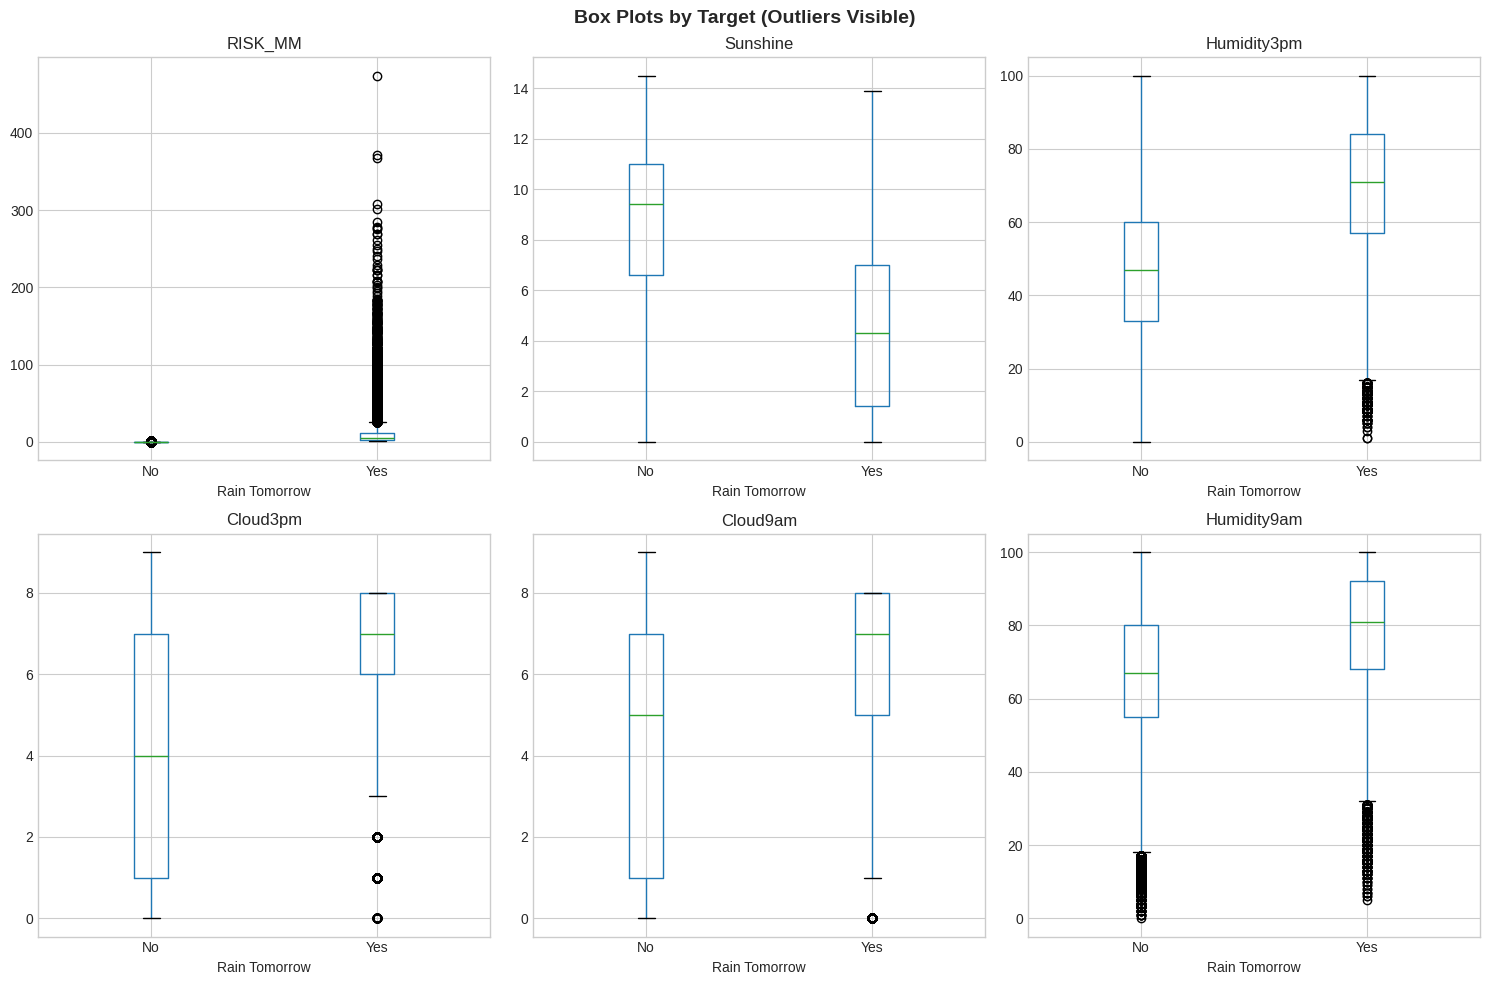

In [55]:
# Box plots for key features
key_features = target_corr.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, key_features):
    df_clean.boxplot(column=col, by='RainTomorrow', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Rain Tomorrow')

plt.suptitle('Box Plots by Target (Outliers Visible)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Feature Engineering

In [56]:
#Convert data to DateTime
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Day'] = df_clean['Date'].dt.day
df_clean['DayOfWeek'] = df_clean['Date'].dt.dayofweek
df_clean['Quarter'] = df_clean['Date'].dt.quarter

#Season (Aus - Southern Hemisphere)
def get_season(month):
  if month in [12, 1, 2]:
    return 'Summer'
  elif month in [3, 4, 5]:
    return 'Autumn'
  elif month in [6, 7, 8]:
    return 'Winter'
  else:
    return 'Spring'

df_clean['Season'] = df_clean['Month'].apply(get_season)

df_clean[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Season']].head()


,Date,Year,Month,Day,DayOfWeek,Quarter,Season
0,2008-12-01,2008,12,1,0,4,Summer
1,2008-12-02,2008,12,2,1,4,Summer
2,2008-12-03,2008,12,3,2,4,Summer
3,2008-12-04,2008,12,4,3,4,Summer
4,2008-12-05,2008,12,5,4,4,Summer


In [57]:
#Temperature features
df_clean['TempRange'] = df_clean['MaxTemp'] - df_clean['MinTemp']
df_clean['TempAvg'] = (df_clean['MaxTemp'] + df_clean['MinTemp']) / 2

#Humidity features
df_clean['HumidityChange'] = df_clean['Humidity3pm'] - df_clean['Humidity9am']
df_clean['HumidityAvg'] = (df_clean['Humidity3pm'] + df_clean['Humidity9am']) / 2

#Pressure features
df_clean['PressureChange'] = df_clean['Pressure3pm'] - df_clean['Pressure9am']

#Cloud Features
df_clean['CloudChange'] = df_clean['Cloud3pm'] - df_clean['Cloud9am']
df_clean['CloudAvg'] = (df_clean['Cloud3pm'] + df_clean['Cloud9am']) / 2

#Wind Features
df_clean['WindSpeedAvg'] = (df_clean['WindSpeed3pm'] + df_clean['WindSpeed9am']) / 2

print("New Features created")

New Features created


In [58]:
# Rain Today as binary
df_clean['RainToday_binary'] = (df_clean['RainToday'] == 'Yes').astype(int)

# Check correlation of new features with target
new_features = ['TempRange', 'TempAvg', 'HumidityChange', 'HumidityAvg',
                'PressureChange', 'CloudChange', 'CloudAvg', 'WindSpeedAvg', 'RainToday_binary']

df_clean['RainTomorrow_binary'] = (df_clean['RainTomorrow'] == 'Yes').astype(int)

new_corr = df_clean[new_features + ['RainTomorrow_binary']].corr()['RainTomorrow_binary'].drop('RainTomorrow_binary')

print("Engineered Features Correlation with Target:")
print("="*50)
print(new_corr.sort_values(key=abs, ascending=False))

Engineered Features Correlation with Target:
CloudAvg            0.382168
HumidityAvg         0.381985
TempRange          -0.336083
RainToday_binary    0.314116
HumidityChange      0.265098
WindSpeedAvg        0.100541
PressureChange      0.095283
CloudChange         0.053600
TempAvg            -0.045206
Name: RainTomorrow_binary, dtype: float64


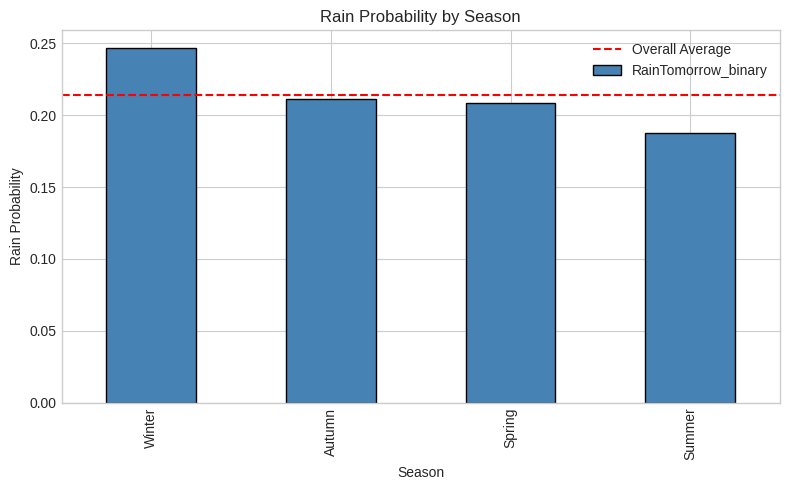

In [59]:
#season impact on rain
season_rain = df_clean.groupby('Season')['RainTomorrow_binary'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
season_rain.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.axhline(y=df_clean['RainTomorrow_binary'].mean(), color='red', linestyle='--', label="Overall Average")
ax.set_xlabel('Season')
ax.set_ylabel('Rain Probability')
ax.set_title("Rain Probability by Season")
ax.legend()

plt.tight_layout()
plt.show()

Feature selection & Dimensionality reduction

In [60]:
drop_cols = ['Date', 'RainTomorrow', 'RainTomorrow_binary', 'Location',
                'WindGustDir','WintDir9am', 'WindDir3pm', 'RainToday', 'Season']

feature_cols = [col for col in df_clean.columns if col not in drop_cols]

print(f"Feature columns: ({len(feature_cols)}): {feature_cols}")

Feature columns: (32): ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindDir9am', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'TempRange', 'TempAvg', 'HumidityChange', 'HumidityAvg', 'PressureChange', 'CloudChange', 'CloudAvg', 'WindSpeedAvg', 'RainToday_binary']


In [61]:
#Prepare data for feature selection (need complete cases)
df_selection = df_clean[feature_cols + ['RainTomorrow_binary']].dropna()

x_selection = df_selection[feature_cols]
y_selection = df_selection['RainTomorrow_binary']

print(f"Shape: {x_selection.shape}")

Shape: (78725, 32)


In [62]:
#SelectingKbest with F-score
# Filter x_selection to only include numeric columns for SelectKBest
numeric_feature_cols = x_selection.select_dtypes(include=np.number).columns.tolist()
x_selection_numeric = x_selection[numeric_feature_cols]

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(x_selection_numeric, y_selection)

feature_scores = pd.DataFrame({
    'Feature': numeric_feature_cols, # Use the filtered numeric columns for scores
    'F-score': selector.scores_
}).sort_values('F-score', ascending=False)

print(feature_scores.to_string(index=False))

         Feature      F-score
         RISK_MM 26904.343989
        Sunshine 20372.436286
     Humidity3pm 20143.811138
        CloudAvg 14469.739528
     HumidityAvg 14382.539194
        Cloud3pm 14069.971809
       TempRange  9368.054839
        Cloud9am  8925.978838
RainToday_binary  8314.787268
  HumidityChange  6102.263099
        Rainfall  5768.374824
     Humidity9am  5754.205728
     Pressure9am  5127.747018
   WindGustSpeed  4363.106372
     Pressure3pm  4012.717671
         Temp3pm  2819.690642
         MaxTemp  1765.681297
     Evaporation  1193.394758
  PressureChange   808.950416
    WindSpeedAvg   627.445563
    WindSpeed9am   515.486625
         MinTemp   476.531130
    WindSpeed3pm   436.892342
     CloudChange   277.307087
         TempAvg   146.839252
         Temp9am    35.030871
            Year    10.078011
             Day     1.546246
           Month     0.813679
         Quarter     0.277295
       DayOfWeek     0.021738


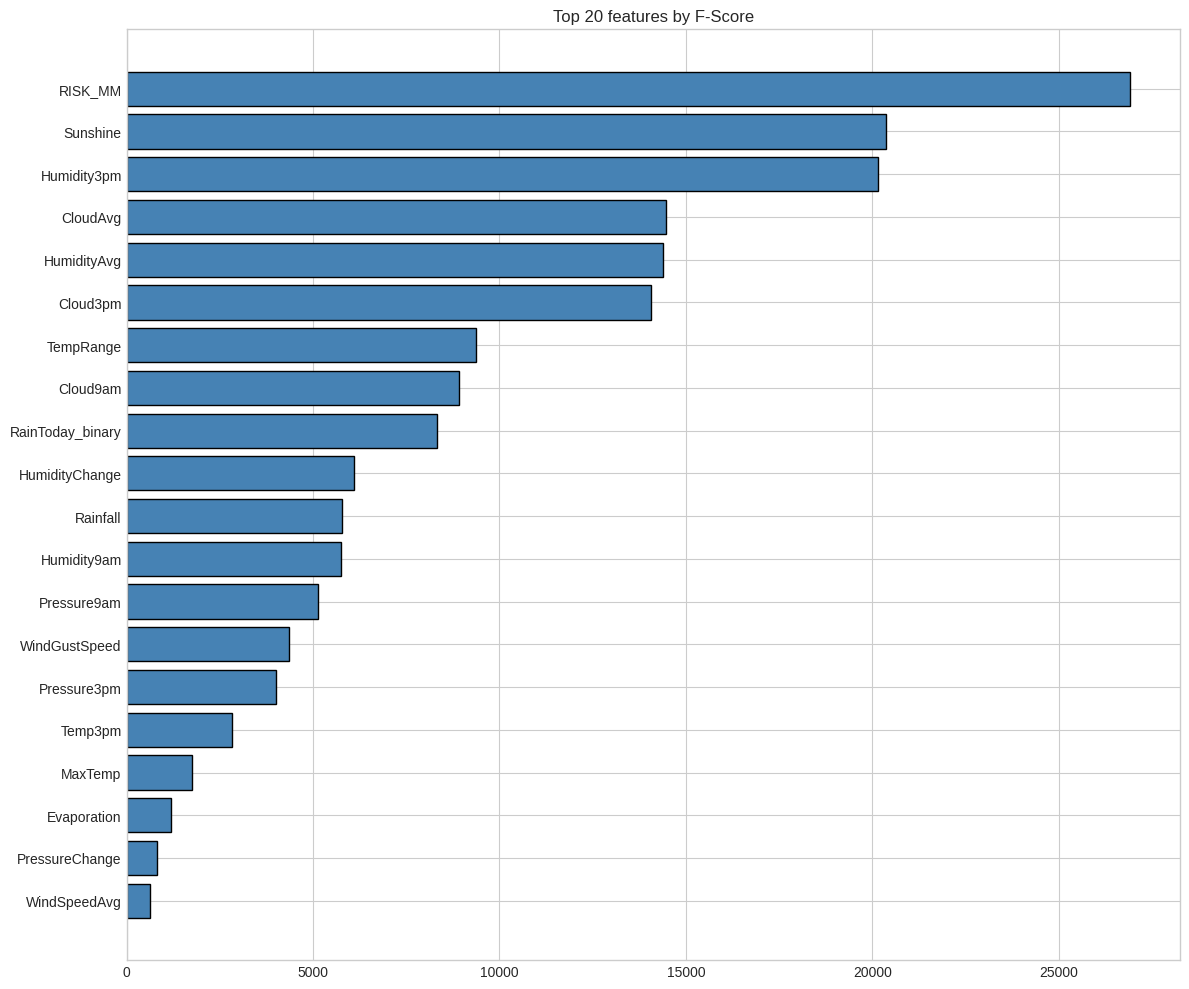

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))

top_features = feature_scores.head(20)
ax.barh(range(len(top_features)), top_features['F-score'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_title('Top 20 features by F-Score')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [64]:
#select top features
top_k = 15
selected_features = feature_scores.head(top_k)['Feature'].tolist()

print(f"\n Selected Top {top_k} Features:")
print(selected_features)


 Selected Top 15 Features:
['RISK_MM', 'Sunshine', 'Humidity3pm', 'CloudAvg', 'HumidityAvg', 'Cloud3pm', 'TempRange', 'Cloud9am', 'RainToday_binary', 'HumidityChange', 'Rainfall', 'Humidity9am', 'Pressure9am', 'WindGustSpeed', 'Pressure3pm']


Explained Variance Ratio: [0.2458164  0.16495346]


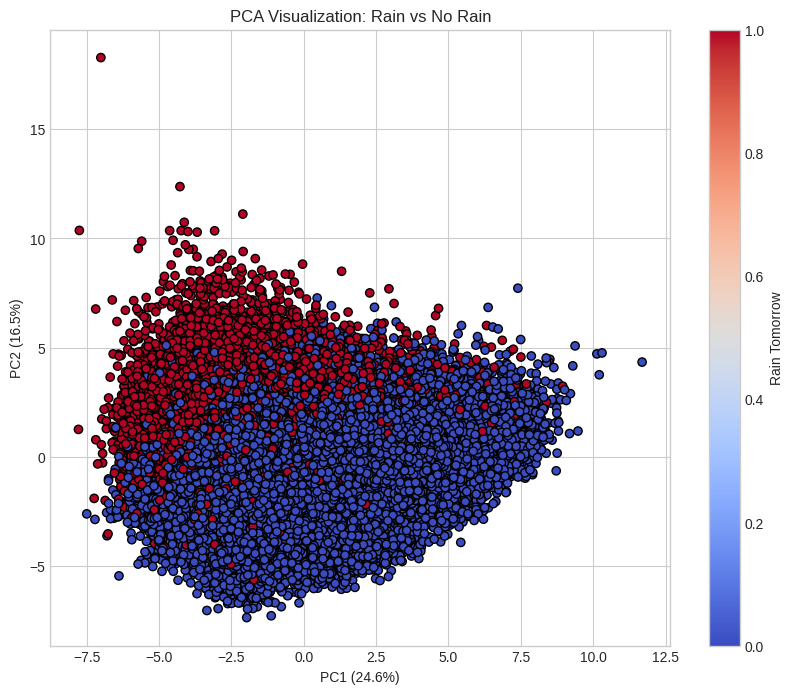

In [65]:
#PCA Visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_selection_numeric)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1],
                     c=y_selection, cmap='coolwarm', edgecolor='black')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA Visualization: Rain vs No Rain')
plt.colorbar(scatter, label='Rain Tomorrow')

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Handle Imbalanced data

In [66]:
# Check class imbalance
print("Class Distribution:")
print("="*40)
print(df_clean['RainTomorrow'].value_counts())
print(f"\nImbalance ratio: {df_clean['RainTomorrow'].value_counts()['No'] / df_clean['RainTomorrow'].value_counts()['Yes']:.1f}:1")

Class Distribution:
RainTomorrow
No     208393
Yes     58924
Name: count, dtype: int64

Imbalance ratio: 3.5:1


Build Pipeline & Prevent Leakage

In [67]:
#Define features groups
numeric_features = [f for f in selected_features if f in numeric_cols or f in new_features]
categorical_features = ['Location', 'WindGustDir', 'RainToday', 'Season']

#Check with categorical features exist
categorical = [f for f in categorical_features if f in df_clean.columns]

print(f"Numeric features: ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features: ({len(categorical_features)}): {categorical_features}")

Numeric features: (15): ['RISK_MM', 'Sunshine', 'Humidity3pm', 'CloudAvg', 'HumidityAvg', 'Cloud3pm', 'TempRange', 'Cloud9am', 'RainToday_binary', 'HumidityChange', 'Rainfall', 'Humidity9am', 'Pressure9am', 'WindGustSpeed', 'Pressure3pm']
Categorical features: (4): ['Location', 'WindGustDir', 'RainToday', 'Season']


In [68]:
#Prepare x and y
all_features = numeric_features + categorical_features

x = df_clean[all_features].copy()
y = (df_clean['RainTomorrow'] == 'Yes').astype(int)

print(f"Shape: {x.shape}")
print(f"Target shape: {y.shape}")

Shape: (275410, 19)
Target shape: (275410,)


In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {x_train.shape[0]:,} samples")
print(f"Test shape: {x_test.shape[1]:,} samples")

Train shape: 220,328 samples
Test shape: 19 samples


In [70]:
#Preprocessing pipeline

#Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
],
    remainder='drop'
)

print("Pipeline created")

Pipeline created


In [71]:
#Model 01
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000, class_weight='balanced'))
])

#Model 02
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1))
])

#Model 03
pipe_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

print('Model Pipelines created')

Model Pipelines created


In [74]:
models = {
    'Logistic Regression': pipe_lr,
    'Random Forest': pipe_rf,
    'Gradient Boosting': pipe_gb
}

cv_results = []

for name, model in models.items():
  print(f"\nTraining {name}. . .")

  #Accuracy
  cv_acc = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

  #F1
  cv_f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1', n_jobs=-1)

  #ROC-AUC
  cv_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

  cv_results.append({
      'Model': name,
      'Accuracy': f"{cv_acc.mean():.3f} (+- {cv_acc.std():.3f})",
      'F1': f"{cv_f1.mean():.3f} (+- {cv_f1.std():.3f})",
      'ROC-AUC': f"{cv_auc.mean():.3f} (+- {cv_auc.std():.3f})"

  })
  print(f" Accuracy: {cv_acc.mean():.3f} (+-{cv_acc.std():.3f})")
  print(f" F1: {cv_f1.mean():.3f} (+-{cv_f1.std():.3f})")
  print(f"  ROC-AUC: {cv_auc.mean():.3f} (±{cv_auc.std():.3f})")

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))


Training Logistic Regression. . .
 Accuracy: 0.996 (+-0.000)
 F1: 0.990 (+-0.001)
  ROC-AUC: 1.000 (±0.000)

Training Random Forest. . .
 Accuracy: 1.000 (+-0.000)
 F1: 1.000 (+-0.000)
  ROC-AUC: 1.000 (±0.000)

Training Gradient Boosting. . .
 Accuracy: 1.000 (+-0.000)
 F1: 1.000 (+-0.000)
  ROC-AUC: 1.000 (±0.000)
              Model         Accuracy               F1          ROC-AUC
Logistic Regression 0.996 (+- 0.000) 0.990 (+- 0.001) 1.000 (+- 0.000)
      Random Forest 1.000 (+- 0.000) 1.000 (+- 0.000) 1.000 (+- 0.000)
  Gradient Boosting 1.000 (+- 0.000) 1.000 (+- 0.000) 1.000 (+- 0.000)


Final Model Evaluation

In [75]:
for name, model in models.items():
  model.fit(x_train, y_train)
  print(f"{name} Model Trained!")

Logistic Regression Model Trained!
Random Forest Model Trained!
Gradient Boosting Model Trained!


In [76]:
test_results = []

for name, model in models.items():
  y_pred = model.predict(x_test)
  y_prob = model.predict_proba(x_test)[:, 1]

  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob)

  test_results.append({
      'Model': name,
      'Accuracy': acc,
      'Precision': prec,
      'Recall': rec,
      'F1': f1,
      'ROC-AUC': auc
  })

  test_result_df = pd.DataFrame(test_results)
  print(test_result_df.round(3).to_string(index=False))

              Model  Accuracy  Precision  Recall    F1  ROC-AUC
Logistic Regression     0.996      0.983     1.0 0.991      1.0
              Model  Accuracy  Precision  Recall    F1  ROC-AUC
Logistic Regression     0.996      0.983     1.0 0.991      1.0
      Random Forest     1.000      1.000     1.0 1.000      1.0
              Model  Accuracy  Precision  Recall    F1  ROC-AUC
Logistic Regression     0.996      0.983     1.0 0.991      1.0
      Random Forest     1.000      1.000     1.0 1.000      1.0
  Gradient Boosting     1.000      1.000     1.0 1.000      1.0


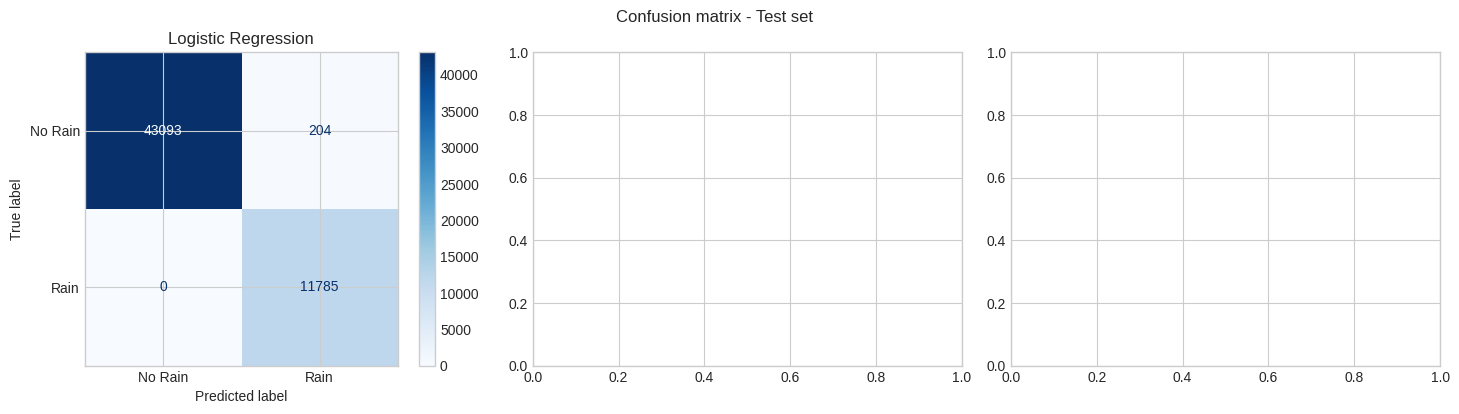

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [82]:
#Confusion matrices
fig, axes = plt.subplots(1,3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models.items()):
  y_pred = model.predict(x_test)
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          display_labels=['No Rain', 'Rain'], cmap='Blues', ax=ax)
  ax.set_title(name)
  plt.suptitle("Confusion matrix - Test set")
  plt.tight_layout()
  plt.show()

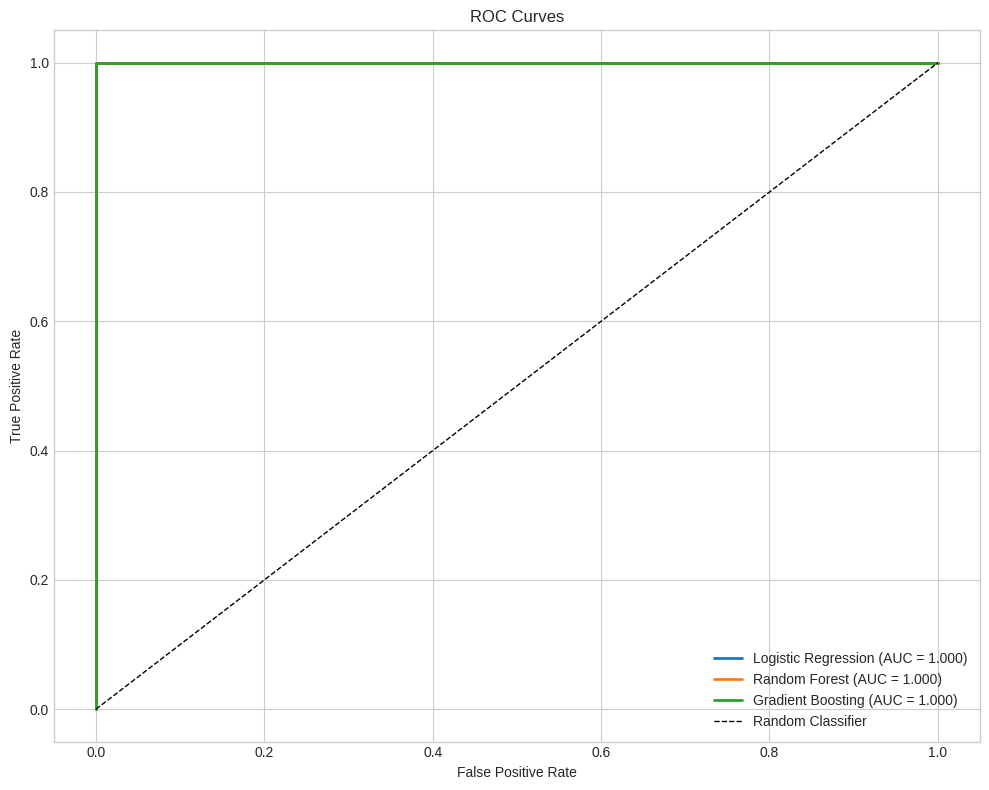

In [83]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in models.items():
  y_prob = model.predict_proba(x_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  auc = roc_auc_score(y_test, y_prob)
  ax.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [87]:
#%%
# Best model detailed report
best_model_name = test_result_df.loc[test_result_df['ROC-AUC'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"BEST MODEL: {best_model_name}")
print("="*60)

y_pred_best = best_model.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Rain', 'Rain']))

BEST MODEL: Random Forest

Classification Report:
              precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00     43297
        Rain       1.00      1.00      1.00     11785

    accuracy                           1.00     55082
   macro avg       1.00      1.00      1.00     55082
weighted avg       1.00      1.00      1.00     55082

